# EDA & Data Cleaning - Echo Chambers

The following code cells process the raw data as downloaded from [MovieLens](https://grouplens.org/datasets/movielens/) in preparation for analysis.

## Local Code Imports - Do not delete

In [188]:
# DO NOT REMOVE THESE
%load_ext autoreload
%autoreload 2

In [189]:
# DO NOT REMOVE This
%reload_ext autoreload

In [190]:
# Uncomment to filter warnings
#import warnings
# warnings.filterwarnings('ignore')

In [2]:
# DO NOT REMOVE
# import local src module -
# src in this project will contain all your local code
## clean_data.py, model.py, visualize.py, custom.py
from src import make_data as mk
from src import visualize as viz
from src import model as mdl
from src import pandas_operators as po


def test_src():
    mk.test_make_data()
    viz.test_viz()
    mdl.test_model()
    po.test_pandas()

    return 1

In [3]:
test_src()

In make_data
In Visualize
In Model
In pandas ops


1

## Code Imports

In [4]:
# Some standard imports
import seaborn as sns
import numpy as np
import pandas as pd

# import pandas_profiling as pp  # uncomment if you want to use pandas_profiling
# must have pandas_profiling installed locally.
##
# pip install pandas-profiling
##

import matplotlib.pyplot as plt
%matplotlib inline

# Project Overview


The purpose of this project is to create a recommendation system that overcomes the echo chamber problem. The echo chamber problem occurs when additional information provided to a recommendation system results in a decrease in the diversity of recommendations for a given user. The result is a recommendation system that reinforces a user’s recorded preferences and fails to provide recommendations outside the user’s typical purview.

In order to overcome the echo chamber problem, this project builds a system that provides additional recommendations based on the preferences of others who are different, but not too different, from the user. These additional recommendations are identified by clustering users based on the latent user features from an ALS decomposition of a ratings matrix. Once clusters are created, the top-rated items from users in each cluster can be identified. The top-rated items in each cluster form the set of items from which the recommendations will be extracted. To get recommendations for a user, the following steps occur:

The distance between clusters is measured,
A user is classified into a cluster,
From the nearest cluster to the user’s cluster, a random selection of items is recommended to the user.
Step three can be repeated for the k nearest clusters. In such a case, the proportion of total recommendations selected from a cluster is weighted by the cluster’s distance from the user’s cluster. (For example, for k=3 and a total of 10 recommendations, 5 recommendations may be selected from the nearest cluster, 3 from the second nearest, and 2 from the third nearest.)

## Data Description

The project utilizes the MovieLens dataset (Harper & Konstan, 2015). The MovieLens dataset is an open source data set containing 27,753,444 movie ratings from 283,228 users for 58,098 movies. The ratings are on a five-star scale range from 0.5 stars to 5 stars in 0.5 star increments. The files include data from January 09, 1995 and September 26, 2018. The data set includes a random sample of users with at least 1 movie rating.

### Data Dictionary

userId - A unique identifier for each user in the dataset

movieId - A unique identifier for each movie in the dataset

rating - A user's rating for a given movie. The ratings utilize a five star system ranging from 0.5 stars to 5 stars in 0.5 star increments. 

timestamp - The timestamp is the time at which the rating was made represented as seconds since midnight January 1, 1970 (UTC).

# EDA

## Load Data - All sources

In [7]:
ratings_df = pd.read_csv('../data/raw/ratings.csv')

## Data Summary

In [8]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


In [9]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
userId       int64
movieId      int64
rating       float64
timestamp    int64
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [10]:
ratings_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [11]:
ratings_df.rating.value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

## Evaluating Users

In [12]:
ratings_df['userId'].nunique()

283228

In [13]:
user_counts = ratings_df.groupby(['userId']).agg('count')
user_counts.drop(['rating', 'timestamp'], axis=1, inplace=True)
user_counts.columns = ['counts']

In [14]:
user_counts[user_counts < 10].count()

counts    39570
dtype: int64

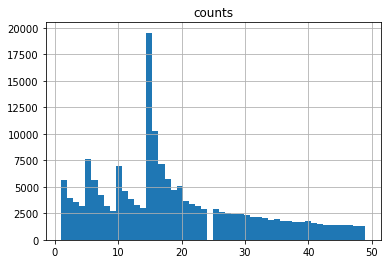

In [15]:
user_counts[user_counts < 50].hist(bins=50)

## Evaluating Movies

In [16]:
ratings_df['movieId'].nunique()

53889

In [17]:
movie_counts = ratings_df.groupby(['movieId']).agg('count')
movie_counts.drop(['rating', 'timestamp'], axis=1, inplace=True)
movie_counts.columns = ['counts']

In [21]:
movie_counts[movie_counts < 5].count()

counts    23065
dtype: int64

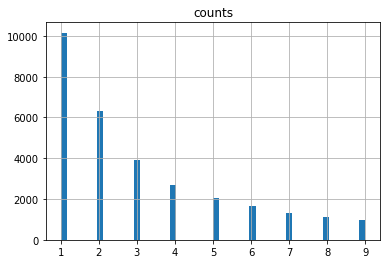

In [19]:
movie_counts[movie_counts < 10].hist(bins=50)

# Data Cleaning

The following cell removes the timestamp column since it will not be used in this recommendation system.

In [24]:
ratings_df.drop(['timestamp'], axis=1, inplace=True)

The next cell creates a series of boolean values indicating whether a user has rated 10 or more movies.  Users with too few ratings negatively impact the root mean square error of the ALS. The cutoff for the minimum number of movie ratings was set to 10 to coincide with the number of recommendations new users will be asked to make to get recommendations from the final recommendation engine. The new series is then checked for missing values and merged with the ratings dataframe. 

In [37]:
ratings_10 = ratings_df.groupby(['userId'])['movieId'].agg('count') >= 10
ratings_10 = ratings_10.reset_index()
ratings_10.head()

,userId,movieId
0,1,True
1,2,True
2,3,True
3,4,True
4,5,True


In [26]:
ratings_10.isna().sum()

userId     0
movieId    0
dtype: int64

In [27]:
df_with_user_filter = ratings_df.merge(ratings_10, on='userId', how='left')
df_with_user_filter.head()

,userId,movieId_x,rating,movieId_y
0,1,307,3.5,True
1,1,481,3.5,True
2,1,1091,1.5,True
3,1,1257,4.5,True
4,1,1449,4.5,True


In [28]:
df_with_user_filter['movieId_y'].value_counts(),

(True     27565774
 False      187670
 Name: movieId_y, dtype: int64,)

The next cell filters the ratings dataframe to create a dataframe that includes only those users with 10 or more recommendations. 

In [29]:
df_filtered = df_with_user_filter[df_with_user_filter['movieId_y'] == True]
df_filtered.drop(['movieId_y'], axis=1, inplace=True)
df_filtered.columns = ['userId', 'movieId', 'rating']
df_filtered.head()

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In the following cell, a final check is conducted to make sure that the number of users in the new dataframe plus the number of users with fewer than 10 ratings is equal to the total number of users in the original ratings dataframe.

In [30]:
df_filtered['userId'].nunique()+(ratings_df.groupby(['userId'])
                                 ['movieId'].agg('count') < 10).sum() == ratings_df['userId'].nunique()

True

In [85]:
movie_filter = df_filtered.groupby(['movieId'])['userId'].agg('count') > 5
movie_filter = movie_filter.reset_index()
movie_filter.head()

,movieId,userId
0,1,True
1,2,True
2,3,True
3,4,True
4,5,True


In [86]:
df_filtered_with_movie_filter = df_filtered.merge(
    movie_filter, on='movieId', how='left',)

In [87]:
df_filtered_with_movie_filter.head()

,userId_x,movieId,rating,userId_y
0,1,307,3.5,True
1,1,481,3.5,True
2,1,1091,1.5,True
3,1,1257,4.5,True
4,1,1449,4.5,True


In [88]:
cleaned_df = df_filtered_with_movie_filter[df_filtered_with_movie_filter['userId_y'] == True]

In [89]:
cleaned_df.drop(['userId_y'], axis=1, inplace=True)

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [91]:
cleaned_df.columns = ['userId', 'movieId', 'rating']
cleaned_df.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [93]:
len(cleaned_df)

27510397

Lastly, the new filtered dataframe is saved to the processed data folder.

In [94]:
cleaned_df.to_csv('../data/processed/ratings_processed.csv')

# Movie Data

The movie dataset contains information on the title, release date, and genre of 58,098 movies. The recommendation function developed through this project utilizes several versions of movie dataset. The following code creates a dataset of most rated movies (i.e., movies with at more than 50 user ratings) and the 100 top rated movies (based on highest mean rating) among the most rated movies. 

In [5]:
movies_df = pd.read_csv('../data/raw/movies.csv')
movie_ratings = pd.read_csv(
    '../data/processed/ratings_processed.csv', index_col=['Unnamed: 0'])

/anaconda3/envs/FI_final_project/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [195]:
mean_ratings = movie_ratings.groupby(['movieId'])['rating'].agg('mean')
mean_ratings = mean_ratings.reset_index()
mean_ratings.columns = ['movieId', 'rating']

In [196]:
total_recs = (movie_ratings['movieId'].value_counts()).reset_index()
total_recs.columns = ['movieId', 'total_recs']
total_recs = total_recs[total_recs['total_recs'] > 50]

In [197]:
most_rated = pd.merge(total_recs, mean_ratings, how='left', on='movieId')
most_rated_sorted = most_rated.sort_values(by='rating', ascending=False)

In [198]:
top_100 = most_rated_sorted[:100]
top_100 = pd.merge(top_100, movies_df, how='left', on='movieId')

In [199]:
top_100.to_csv('../data/processed/top_100.csv')

In [183]:
most_rated_df = pd.merge(most_rated_sorted, movies_df,
                         how='left', on='movieId')
most_rated_df.drop(['total_recs'], axis=1, inplace=True)

In [184]:
most_rated_df.drop(['rating'], axis=1, inplace=True)

In [186]:
most_rated_df.to_csv('../data/processed/most_rated.csv')